# Telework Analysis for Tonia

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in Tonia's data sheet
dataSheet = pd.read_excel('FINAL DATA SHEET FOR ANALYSIS.xlsx')

# Add -1 as supervisor for all individuals with no supervisors
dataSheet['SUPERVISOR FORMULA'] = dataSheet['SUPERVISOR FORMULA'].fillna(-1)

# Remove the IDs whose presence erroneously causes an infinite loop 
#   in the data, as they are incorrectly supervising each other

errorIDs = [32459790,
            18776524,
            5739360,
            42535892]

dataSheet = dataSheet.loc[~dataSheet['RANDOM EMPLOYEE ID'].isin(errorIDs),:]

# Display summarized alternate work information on all employees in the records
summaryStats = dataSheet.loc[:,['TS_hours','TW_hours','TM_hours']].describe().T
summaryStats

,count,mean,std,min,25%,50%,75%,max
TS_hours,28876.0,65.952168,112.360501,0.0,8.0,28.0,77.5,1594.5
TW_hours,28876.0,160.390208,248.565769,0.0,0.0,26.0,241.5,1943.0
TM_hours,28876.0,7.440279,70.635317,0.0,0.0,0.0,0.0,1876.5


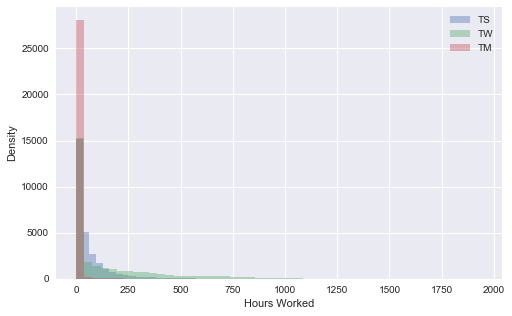

In [3]:
# Graph raw density distributions via histograms across all data.

sns.set()

fig, ax = plt.subplots(figsize=(8,5))

sns.distplot(dataSheet['TS_hours'].fillna(0), label='TS', ax = ax, kde=False)
sns.distplot(dataSheet['TW_hours'].fillna(0), label='TW', ax = ax, kde=False)
sns.distplot(dataSheet['TM_hours'].fillna(0), label='TM', ax = ax, kde=False)

ax.set(xlabel="Hours Worked", ylabel="Density")
plt.legend()
plt.show()

# As we can see, there are a TON of zeroes & low values here. TW 
#   has a bit of a fatter distribution in the 0-1000 range. TM, 
#   as expected from summary statistics above, has low density 
#   pretty much everywhere due to the massive weighting towards 0.

In [4]:
def directReports(df, usr = "RANDOM EMPLOYEE ID", 
                      sup = "SUPERVISOR FORMULA"):
    
    ''' This statement sums up how many times each individual 
        appears in the supervisor row, thus estimating their
        number of direct subordinates. This is validated later
        using the tree comprehension logic, to ensure that the
        tree builder is working correctly. '''
    
    df['directReports'] = [sum(df[sup]==person) for person in df[usr]]
    
    return df

dataSheet = directReports(dataSheet)

In [5]:
def subTree(person, orderedPairs):
    
    ''' Generate recursive tree dictionary from an individual. 
        Must convert the lists into ordered pairs for efficiency. '''
    
    return {
        v: subTree(v, orderedPairs)
        for v in [x[0] for x in orderedPairs if x[1] == person]
    }

def treeDepth(d):
    ''' Recursive function to calculate dictionary depth '''
    if (not isinstance(d, dict) or not d): 
        return 0
    else:
        return max(treeDepth(v) for k, v in d.items()) + 1

def nestedCount(d):
    ''' Recursive function to calculate total dictionary count'''
    return sum([1 if v == {} else nestedCount(v) for v in d.values()])

In [6]:
def estimateLevelsBelow(df, 
                   usr = "RANDOM EMPLOYEE ID", 
                   sup = "SUPERVISOR FORMULA"):
    
    ''' Function that adds columns to estimate how many levels 
        below that employee exist in the data. 
        
        The way this works is quite straightforward; for all 
        employees, we are tracking through the supervisor column
        to count the number of employees that are supervised by
        that specific person. Then we track down to assess how many
        users are supervised by THOSE people, and how many levels
        you have to go to get to a group with no direct reports.
        
        There are a few drawbacks to this. First, it's really slow.
        Second, because the dataset is incomplete (due to only having
        employees with this sort of work type), this could miss many
        elements of reporting structure. But it should at least give
        a few large trees that help demonstrate Tonia's goal.
        
        OPTIONS:
           - df     pandas DF    the data
           - usr    str          name of the user ID column
           - sup    str          name of the supervisor ID column'''
    
    # In order to make this tree comprehension faster, I turned 
    #   the supervisor/employee relationship into a large set
    #   of ordered pairs. Python can access these WAY quicker.
    
    relationTrees = [(x[1][usr],x[1][sup]) for x in df.iterrows()]
    
    directReports = []
    aggReports    = []
    reportDepth   = []
    
    for idx, person in enumerate(df[usr]):
        try: 
            personTree = subTree(person,relationTrees)
            reportDepth = reportDepth + [treeDepth(personTree)]
            aggReports  = aggReports + [nestedCount(personTree)]
            directReports = directReports + [len(personTree.items())]
            if (idx % 1000) == 0: print(idx)
                
        except:
            print('ERROR! Arrived at idx={}, person={}'.format(idx,person))
            reportDepth = reportDepth + [-1]
            aggReports  = aggReports + [-1]
            directReports = directReports + [-1]
    
    df['directReports2'] = directReports
    df['aggReports']     = aggReports
    df['reportDepth']    = reportDepth
                           
    return df
    
dataSheet = estimateLevelsBelow(dataSheet)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [22]:
# Initial analysis pointed to a whoooole lot of people with nobody reporting
#   to them in this data. This isn't completely unexpected, given the 
#   aformentioned issues with missing data. However, it will impact analysis.

# Assessing those who aren't supervisors by those who have reporting depth = 0
totNonSups     = sum(dataSheet['reportDepth']==0)
totEmp         = len(dataSheet["RANDOM EMPLOYEE ID"])

print('{0:.1%} of records ({1:,}) have nobody below them.'.format(totNonSups/totEmp,totNonSups))

# Assessing those with no supervisors by those whose supervisor = -1, per missing handling above
totMiss    = sum(dataSheet['SUPERVISOR FORMULA']==-1)
print('{0:.1%} of records ({1:,}) are missing a supervisor in the data.'.format(totMiss/totEmp,totMiss))

# Generate list of the orphans, analyze them, and split them out of the data.
dataSheet['orphanStatus'] = (dataSheet['reportDepth']==0) & (dataSheet['SUPERVISOR FORMULA']==-1)

print('{0:.1%} of records ({1:,}) are missing a supervisor AND have nobody below them!\n'.format(sum(dataSheet['orphanStatus'])/totEmp,sum(dataSheet['orphanStatus'])))

# Here, I am analyzing and exporting these specifically, as we cannot study their
#   relationship to supervisors or reporting structure. These are removed after 
#   this cell, only analyzed here.

pd.pivot_table(dataSheet,columns='orphanStatus',
               values=['TS_hours','TM_hours','TW_hours'],
               aggfunc=[len,np.mean]).T

# What you can see here is that the orphans -- people with no supervisors or 
#   reports in the data -- have lower means across the board. They are not 
#   wildly lower, but it's lower enough to begin to validate Tonia's hypothesis
#   that supervisors who do not use these (and aren't in the data) mean subordinates
#   who ALSO utilize less.

94.9% of records (27,396) have nobody below them.
13.5% of records (3,903) are missing a supervisor in the data.
12.5% of records (3,606) are missing a supervisor AND have nobody below them!



TM_hours      TS_hours      TW_hours
     orphanStatus                                          
len  False         25271.000000  25271.000000  25271.000000
     True           3606.000000   3606.000000   3606.000000
mean False             7.522654     67.191755    164.640948
     True              6.862829     57.262677    130.592580

In [25]:
# If we look at ReportDepth, we can find a bunch of people who are essentially at
#   the top of their departments/offices according to the reporting chain described 
#   in this dataset. Those are the folks with reportDepth = 9/8/7

dataSheet['reportDepth'].value_counts()

0    27396
1      992
2      302
3      113
4       43
5       19
6        8
7        2
9        1
8        1
Name: reportDepth, dtype: int64

In [27]:
# Who are they? Let's see!

dataSheet.loc[dataSheet['reportDepth']>5,:]

# If you'd like, these are the employee IDs to focus on if you want 
#   to find the heads of the organizations and split out into different 
#   cohorts. Given this, splitting the cohort of ID = 864748  (~500 
#   hours of TS) vs, say, 37477368 (5 hours) and seeing differences in 
#   the averages in these cohorts is likely going to validate or 
#   disprove your general theory.

,FY_Year,RANDOM EMPLOYEE ID,SUPERVISOR FORMULA,TS_hours,TW_hours,TM_hours,directReports,directReports2,aggReports,reportDepth,orphanStatus
605,2016.0,3430620,1145288.0,81.5,0.0,0.0,4,4,381,6,False
715,2016.0,15215210,1145288.0,190.0,0.0,0.0,8,8,534,6,False
1071,2016.0,3861077,-1.0,0.0,8.0,0.0,16,16,2692,9,False
2393,2016.0,6139875,-1.0,77.5,0.0,0.0,41,41,995,6,False
2982,2016.0,35616,-1.0,80.5,0.0,0.0,28,28,759,6,False
3941,2016.0,5246250,3861077.0,28.0,0.0,0.0,17,17,2578,8,False
4403,2016.0,37477368,1145288.0,5.0,0.0,0.0,4,4,434,6,False
4424,2016.0,1145288,-1.0,44.0,0.0,0.0,64,64,1726,7,False
4843,2016.0,8142762,-1.0,29.0,0.0,0.0,26,26,562,6,False
7032,2016.0,12718944,2512692.0,48.0,0.0,0.0,75,75,1122,6,False


In [39]:
def addSupervisorHours(df, 
                   usr = "RANDOM EMPLOYEE ID", 
                   sup = "SUPERVISOR FORMULA"):
    
    ''' This function adds supervisor hours to the dataset, so that
        you can split on folks with supervisor hours > average and 
        supervisor hours < average. '''
    
    supTS = []
    supTW = []
    supTM = []
    
    for idx, person in enumerate(df[usr]):
        row    = df.loc[df[usr]==person,:]
        supRow = df.loc[df[usr]==row[sup].values[0],:]
        try: 
            supTS = supTS + [supRow['TS_hours'].values[0]]
            supTW = supTW + [supRow['TW_hours'].values[0]]
            supTM = supTM + [supRow['TM_hours'].values[0]]
        except:
            supTS = supTS + [-1]
            supTW = supTW + [-1]
            supTM = supTM + [-1]
                
    df['supTS'] = supTS
    df['supTW'] = supTW
    df['supTM'] = supTM
                           
    return df

dataSheet = addSupervisorHours(dataSheet)

In [40]:
dataSheet.to_csv('fileForTonia.csv')